#Setup

##Import
Importing and installing used libraries

In [47]:
!pip install wget # to download data

In [48]:
from sklearn.decomposition import PCA
from torch import FloatTensor as FT
from torch import LongTensor as LT
import matplotlib.pyplot as plt
import torch.nn as nn
import collections
import numpy as np
import torch
import wget
import json
import os
import re
import json
import csv

#stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# for cute iteration bars (during training etc.)
from tqdm.auto import tqdm

torch.manual_seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Constants
Constants used to create Word2Vec datasets and all useful paths

In [51]:
VOCAB_SIZE = 10_000
UNK = 'UNK'
WINDOW_SIZE = 2
ROOT_FOLDER = '/content/drive/My Drive/NLP/nlp_2022-bonus_exercise_1/code/' # the root is the "code" folder

# some path
TRAIN_DATA_PATH = ROOT_FOLDER + "data/train.jsonl"
DEV_DATA_PATH = ROOT_FOLDER + "data/dev.jsonl"
TEST_DATA_PATH = ROOT_FOLDER + "data/test.jsonl"
PREDICTIONS = ROOT_FOLDER + "predictions/"
TEST_PREDICTION = ROOT_FOLDER + "../predictions/"

# path to store the word embedding checkpoints
PATH_WORD_EMBEDDING_OUTPUT_FOLDER = os.path.join(ROOT_FOLDER, 'embedding_folder/')
# path to store the sentence analysis checkpoints
PATH_MYMODEL_OUTPUT_FOLDER = os.path.join(ROOT_FOLDER, 'sentences_model_checkpoints')

#Word Embedding

##Dataset Word2Vec
Each entry is a pair (target, input):

* The input is the selected word in the sentence;
* The target is a word close to the input in a fixed size window.



In [50]:
class Word2VecDataset(torch.utils.data.IterableDataset):

    def __init__(self, txt_path, vocab_size, unk_token, window_size):
        """
        Args:
          txt_file (str): Path to the dataset file.
          vocab_size (int): Maximum amount of words that we want to embed.
          unk_token (str): How will unknown words represented (e.g. 'UNK').
          window_size (int): Number of words to consider as context.
        """
        self.window_size = window_size
        self.data_words = self.read_data(txt_path)
        self.build_vocabulary(vocab_size, unk_token)

    def __iter__(self):
        sentences = self.data_words
        for sentence in sentences:
            len_sentence = len(sentence)
            for input_idx in range(len_sentence):
                current_word = sentence[input_idx]
                # must be a word in the vocabulary
                if current_word in self.word2id and self.keep_word(current_word):
                    # left and right window indices
                    min_idx = max(0, input_idx - self.window_size)
                    max_idx = min(len_sentence, input_idx + self.window_size)

                    window_idxs = [x for x in range(min_idx, max_idx) if x != input_idx]
                    for target_idx in window_idxs:
                        # must be a word in the vocabulary
                        if sentence[target_idx] in self.word2id:
                            # index of target word in vocab
                            target = self.word2id[sentence[target_idx]]
                            # index of input word
                            current_word_id = self.word2id[current_word]
                            output_dict = {'targets':target, 'inputs':current_word_id}

                            yield output_dict

    def keep_word(self, word):
        '''Implements negative sampling and returns true if we can keep the occurrence as training instance.'''
        z = self.frequency[word] / self.tot_occurrences
        p_keep = np.sqrt(z / 10e-3) + 1
        p_keep *= 10e-3 / z # higher for less frequent instances
        return np.random.rand() < p_keep # toss a coin and compare it to p_keep to keep the word

    def read_data(self, txt_path):
        """
        Converts each line of the input file into 3 paralel list:
            - A list of lists of tokenized words;
            - A list of labels;
            - A list of id.
        """
        data = []
        total_words = 0
        with open(txt_path, 'r') as json_file:
            json_list = list(json_file)

        self.labels = []
        self.id = []
        for json_str in json_list:
            result = json.loads(json_str)
            line = result["text"]
            # If it is the testset, there are no labels 
            if (result.get("label") != None):
                self.labels.append(result["label"])
            self.id.append(result["id"])
            split = self.tokenize_line(line)
            if split:
                data.append(split)
                total_words += len(split)
        return data

    # "The pen is on the table" -> ["the, "pen", "is", "on", "the", "table"]
    def tokenize_line(self, line, pattern='\W'):
        """Tokenizes a single line."""
        sw = stopwords.words('english')
        return [word.lower() for word in re.split(pattern, line.lower()) if 
                (word 
                 and word.isalpha() 
                 and word not in sw
                 and len(word)>1)]

    def build_vocabulary(self, vocab_size, unk_token):
        """Defines the vocabulary to be used. Builds a mapping (word, index) for
        each word in the vocabulary.

        Args:
          vocab_size (int): size of the vocabolary
          unk_token (str): token to associate with unknown words
        """
        counter_list = []
        # context is a list of tokens within a single sentence
        for context in self.data_words:
            counter_list.extend(context)
        counter = collections.Counter(counter_list)
        counter_len = len(counter)
        print("Number of distinct words: {}".format(counter_len))

        # consider only the (vocab size -1) most common words to build the vocab
        dictionary = {key: index for index, (key, _) in enumerate(counter.most_common(vocab_size - 1))}
        assert unk_token not in dictionary
        # all the other words are mapped to UNK
        dictionary[unk_token] = vocab_size - 1
        self.word2id = dictionary

        # dictionary with (word, frequency) pairs
        dict_counts = {x: counter[x] for x in dictionary if x is not unk_token}
        self.frequency = dict_counts
        self.tot_occurrences = sum(dict_counts[x] for x in dict_counts)

        print("Total occurrences of words in dictionary: {}".format(self.tot_occurrences))

        less_freq_word = min(dict_counts, key=counter.get)
        print("Less frequent word in dictionary appears {} times ({})".format(dict_counts[less_freq_word],
                                                                              less_freq_word))

        # index to word
        self.id2word = {value: key for key, value in dictionary.items()}

        # data is the text converted to indexes, as list of lists
        data = []
        # for each sentence
        for sentence in self.data_words:
            paragraph = []
            # for each word in the sentence
            for i in sentence:
                id_ = dictionary[i] if i in dictionary else dictionary[unk_token]
                if id_ == dictionary[unk_token]:
                    continue
                paragraph.append(id_)
            data.append(paragraph)
        # list of lists of indices, where each sentence is a list of indices, ignoring UNK
        self.data_idx = data

In [32]:
print("TRAINSET:")
train_dataset = Word2VecDataset(TRAIN_DATA_PATH, VOCAB_SIZE, UNK, window_size=WINDOW_SIZE)
print("\nDEVSET:")
dev_dataset = Word2VecDataset(DEV_DATA_PATH, VOCAB_SIZE, UNK, window_size=WINDOW_SIZE)
print("\nTESTSET:")
test_dataset = Word2VecDataset(TEST_DATA_PATH, VOCAB_SIZE, UNK, window_size=WINDOW_SIZE)

TRAINSET:
Number of distinct words: 107718
Total occurrences of words in dictionary: 4770799
Less frequent word in dictionary appears 64 times (restart)

DEVSET:
Number of distinct words: 27465
Total occurrences of words in dictionary: 195188
Less frequent word in dictionary appears 3 times (evolved)

TESTSET:
Number of distinct words: 24998
Total occurrences of words in dictionary: 174865
Less frequent word in dictionary appears 3 times (gingrich)


##Model

###Definition

In [52]:
class SkipGram(nn.Module):

    def __init__(self, vocabulary_size, embedding_dim, id2word, word_counts, NEG_SAMPLING=False):
        super(SkipGram, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_dim = embedding_dim

        # matrix W
        self.embeddings = nn.Linear(self.vocabulary_size, self.embedding_dim)
        # matrix W'
        self.output_weights = nn.Linear(self.embedding_dim, self.vocabulary_size)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, input_idx):
        # This method defines the outputs of a forward pass on the model
        input_embeddings = self.embeddings(input_idx)  # compute the embeddings for the input words
        output_embeddings = self.output_weights(input_embeddings)
        output = output_embeddings
        return output

###Trainer

In [53]:
class TrainerEmbedding():
    def __init__(self, model, optimizer, device):

        self.device = device

        self.model = model
        self.optimizer = optimizer

        # starts requires_grad for all layers
        self.model.train()  # we are using this model for training (some layers have different behaviours in train and eval mode)
        self.model.to(self.device)  # move model to GPU if available

    def train(self, train_dataset, output_folder, epochs=1):

        train_loss = 0.0
        for epoch in range(epochs):
            epoch_loss = 0.0
            len_train = 0

            # each element (sample) in train_dataset is a batch
            for step, sample in tqdm(enumerate(train_dataset), desc="Batch", leave=False):
                # inputs in the batch
                inputs = sample['inputs']
                # outputs in the batch
                targets = sample['targets'].to(self.device)

                # one_hot_input : batch size X vocab_size
                one_hot_input = torch.zeros((inputs.shape[0], VOCAB_SIZE), device=self.device)
                # sets the ones corresponding to the input word
                for i, x in enumerate(inputs):
                    one_hot_input[i, x] = 1

                output_distribution = self.model(one_hot_input)
                loss = self.model.loss_function(output_distribution, targets)  # compute loss
                # calculates the gradient and accumulates
                loss.backward()  # we backpropagate the loss
                # updates the parameters
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()
                len_train += 1
            avg_epoch_loss = epoch_loss / len_train

            print('Epoch: {} avg loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            train_loss += avg_epoch_loss
            # save the model state
            torch.save(self.model.state_dict(),
                       os.path.join(output_folder, 
                                    'state_window{}_{}.pt'.format(WINDOW_SIZE, epoch)))

        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss

###Building

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using " + device)

model_word_embedding = SkipGram(VOCAB_SIZE, embedding_dim=300, id2word=train_dataset.id2word,
                                word_counts=train_dataset.frequency)

# define an optimizer (stochastic gradient descent) to update the parameters
optimizer = torch.optim.SGD(model_word_embedding.parameters(), lr=0.02)
trainer_word_embedding = TrainerEmbedding(model_word_embedding, optimizer, device)

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128) #it batches data for us

Using cuda


###Training

In [44]:
avg_loss = trainer_word_embedding.train(dataloader, PATH_WORD_EMBEDDING_OUTPUT_FOLDER, epochs=100)

Batch: 0it [00:00, ?it/s]

KeyboardInterrupt: ignored

###Evaluation
Print the embedding of some words using the first two PCAs, thus showing the similarity in 2D space. Of course, a lot of information is lost, but something is still noticeable.

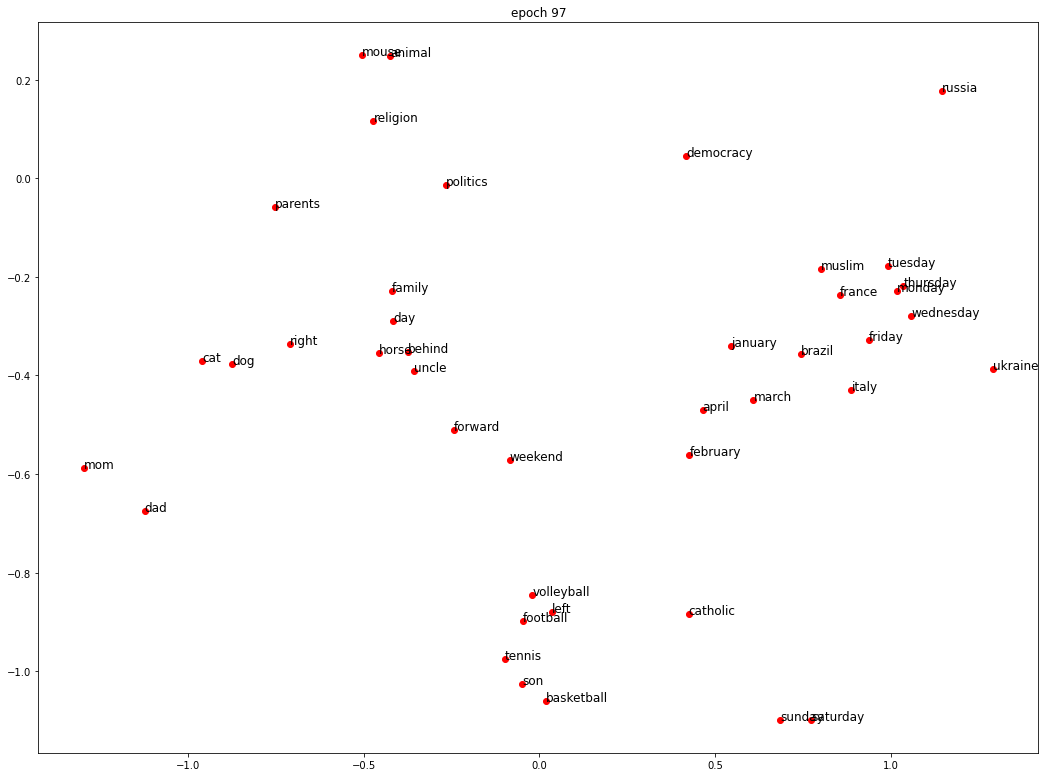

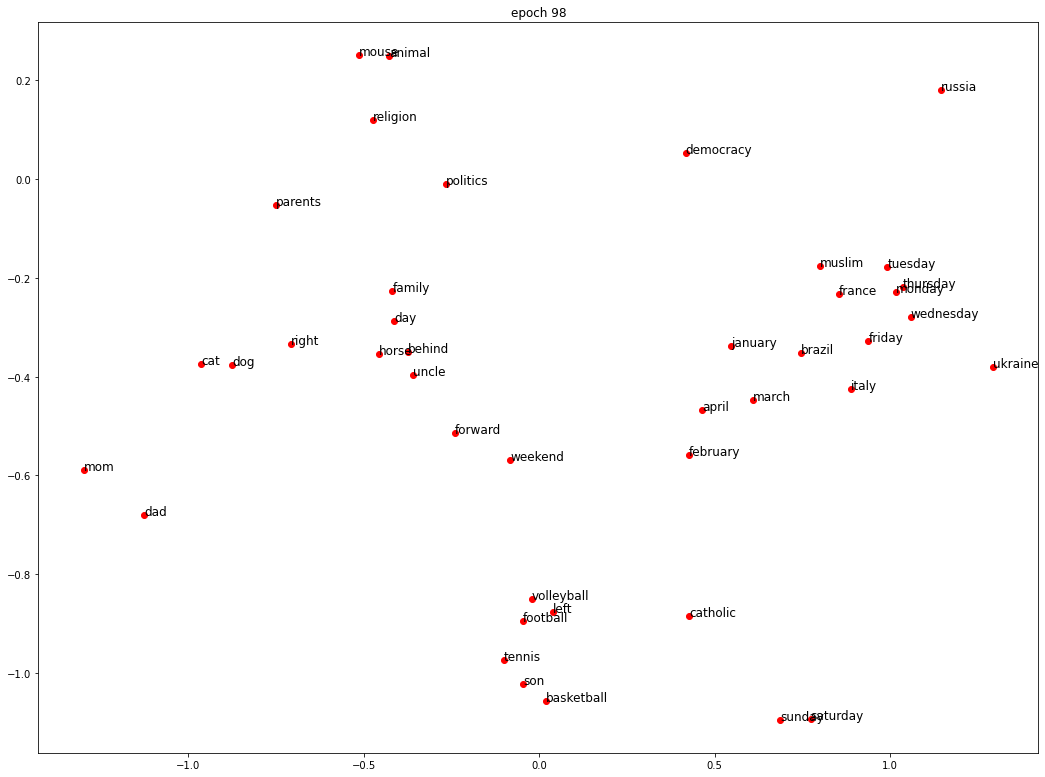

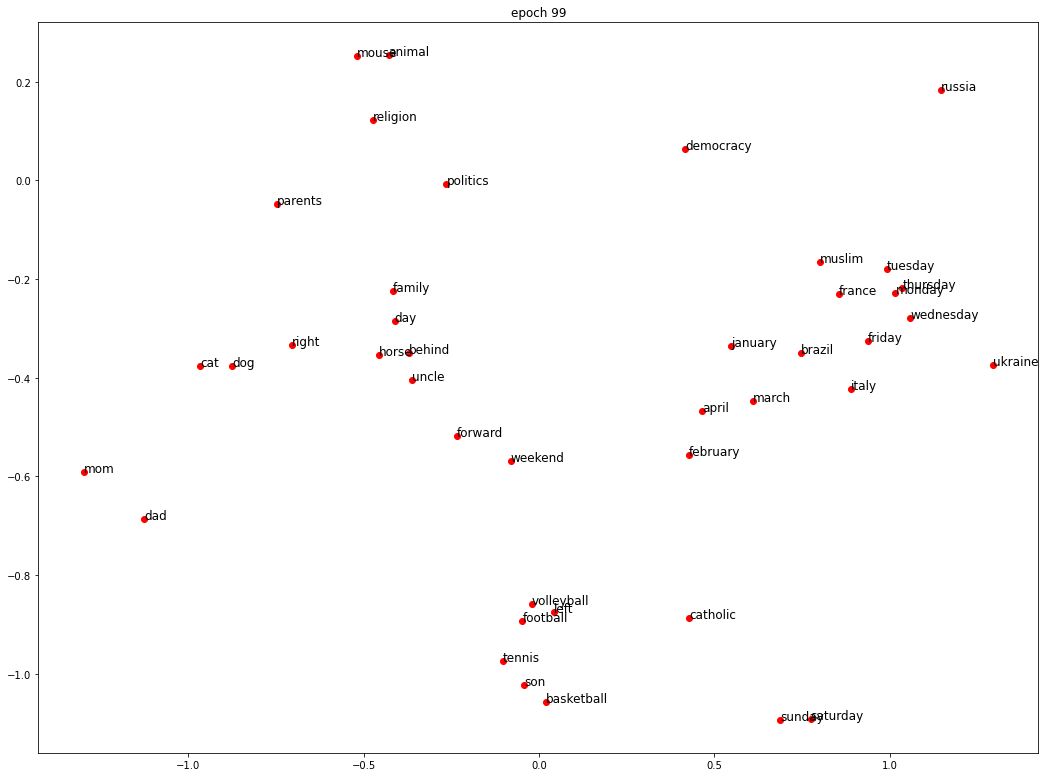

In [54]:
last_checkpoint = 99
for epoch in range(last_checkpoint-2, last_checkpoint+1, 1):
    # load model from checkpoint
    model_word_embedding.load_state_dict(torch.load(os.path.join(PATH_WORD_EMBEDDING_OUTPUT_FOLDER, 
                                                                 'state_window{}_{}.pt'.format(WINDOW_SIZE, epoch))))

    # set the model in evaluation mode
    # (disables dropout, does not update parameters and gradient)
    model_word_embedding.eval()

    # retrieve the trained embeddings
    embeddings = model_word_embedding.embeddings.weight

    # pick some words to visualise
    words = ['russia', 'ukraine', 'france', 'italy', 'brazil',
           'right', 'left', 'forward', 'behind',
           'monday', 'wednesday', 'tuesday','thursday', 'friday', 'day', 'weekend', 'sunday', 'saturday', 
          'dog',  'horse', 'animal', 'cat', 'mouse',
          'january', 'february', 'april', 'march',
          'parents', 'mom', 'dad', 'uncle', 'son', 'family',
          'muslim', 'catholic', 'religion',
          'politics', 'democracy', 
          'basketball', 'volleyball', 'football', 'tennis']
    
    # perform PCA to reduce our 300d embeddings to 2d points that can be plotted
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings.detach().t().cpu()) # .t() transpose the embeddings

    indexes = [train_dataset.word2id[x] for x in words]
    points = [pca_result[i] for i in indexes]
    plt.figure(figsize=(6.4*2.8, 4.8*2.8), constrained_layout=False)
    for i,(x,y) in enumerate(points):
        plt.plot(x, y, 'ro')
        plt.text(x, y, words[i], fontsize=12) # add a point label, shifted wrt to the point
    plt.title('epoch {}'.format(epoch))
    plt.show()
  

#Text Classification

##Utility function

In [59]:
# Save the prediction in a file .tsv with a row defined as: "{id}\t{prediction}"
def save_predictions(path, filename, dataloader_sentences, model, classes):
    model.eval()
    savepath = path + filename
    with open(savepath, 'w', encoding='utf8', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t')
        for step, sample in tqdm(enumerate(dataloader_sentences), desc="Batch", leave=False):
            inputs = sample['inputs'].type(torch.FloatTensor).to("cuda")
            id = sample['id']
            outputs = model(inputs).argmax(1)
            for i in range(outputs.shape[0]):
                writer.writerow([str(id[i].numpy()), classes[outputs[i]]])

#Setup for model for training on gpu and freezing the word embedding layer
def setup_train(model):
        # starts requires_grad for all layers
        model.train()  # we are using this model for training (some layers have different behaviours in train and eval mode)
        model.embedding_layer.weight.requires_grad = False #freeze this layer (word embedding)
        model.embedding_layer.bias.requires_grad = False   #freeze this layer (word embedding)
        model.to("cuda")  # move model to GPU if available  

##Dataset
Each entry is a triple (target, input, id) or, for the test set, (input, id):

* The input is the sentence encoded by summing all one-hot encodings of the words in a sentence plus a value [0, 1) where 0 means that the word appears in at least one sentence of all classes, 1 appears in no sentence of any class;
* The target is the class to which the sentence belongs;
* The id is the identifier of the phrase, useful to save the predictions in a file.


In [55]:
class SentencesDataset(torch.utils.data.IterableDataset):

    def __init__(self, train_dataset, word2vecDataset, vocab_size, classes):
        """
        Args:
          train_dataset (Word2VecDataset):   Word2Vec of the specific dataset.
          word2vecDataset (Word2VecDataset): Word2Vec of the trainset, 
                                             in order to keep the same vocabulary.
          vocab_size (int):                  Vocabulary size.
          classes (list<str>):               List of classes
        """
        self.word2vecDataset = word2vecDataset
        self.train_dataset = train_dataset
        self.vocab_size = vocab_size
        self.classes = np.array(classes)
        self.calc_freq()

    def __iter__(self):
        sentences = self.word2vecDataset.data_words
        sentence_idx = 0
        for sentence in sentences:
            len_sentence = len(sentence)
            sentence_input = np.zeros(self.vocab_size)
            # Index of the class to which the sentence belongs
            if (len(self.word2vecDataset.labels) != 0): # If testset, we dont have the labels
                target = self.word2vecDataset.labels[sentence_idx]
                target = np.where(self.classes == target)[0][0]
            # Id of the sentence
            id = self.word2vecDataset.id[sentence_idx]
            sentence_idx+=1
            for input_idx in range(len_sentence):
                current_word = sentence[input_idx]
                # must be a word in the vocabulary
                if current_word in self.train_dataset.word2id and self.train_dataset.keep_word(current_word):
                    # Sum of the one hot encoding of the all word in the sentence 
                    # plus some things based on training set:
                    #     - value [0, 1) where 0 means that the word appears in at least 
                    #       one sentence of all classes, 1 appears in no one;
                    current_word_id = self.train_dataset.word2id[current_word]
                    num_classes = (len(self.classes) - self.freq_wordxclass[current_word])/(len(self.classes))
                    sentence_input[current_word_id] += 1 + num_classes
            if (len(self.word2vecDataset.labels) != 0): # If testset, we dont have the labels
                output_dict = {'targets':target, 'inputs':sentence_input, "id": id}
            else:
                output_dict = {'inputs':sentence_input, "id": id}
            yield output_dict

    def calc_freq(self):
        """ Function to calculate frequencies """
        self.freq_classxword = {}
        self.freq_wordxclass = {}
        for i, c in enumerate(self.classes):
            self.freq_classxword[c] = np.zeros(self.vocab_size)
        for sentence_idx, sentence in enumerate(self.train_dataset.data_words):
            for word_idx, word in enumerate(sentence):
                if (word in self.train_dataset.word2id):
                    label = self.train_dataset.labels[sentence_idx]
                    word_id = self.train_dataset.word2id[word]
                    self.freq_classxword[label][word_id] += 1
        for i in range(self.vocab_size):
            self.freq_wordxclass[self.train_dataset.id2word[i]] = 0
        for key, value in self.freq_classxword.items():
            for idx, f in enumerate(value):
                if (f != 0):
                    self.freq_wordxclass[self.train_dataset.id2word[idx]] += 1

##Model

###Definition
It passes the input, which is basically the sum of the one-hot encodings of the words in a sentence, to the frozen word embedding layer to embed the sentence. Then the output is passed to a layer that works as sentence embedding and then to the output layer which is the distribution over the classes.

In [56]:
class MyModel(nn.Module):

    def __init__(self, num_classes, embedding_layer, embedding_dim, embedding_sentence_dim):
        super(MyModel, self).__init__()
        # Some dimention
        self.num_classes = num_classes
        self.embedding_sentence_dim = embedding_sentence_dim
        self.embedding_dim = embedding_dim
        
        # Word embedding layer freezed
        self.embedding_layer = embedding_layer
        self.embedding_layer.weight.requires_grad = False
        self.embedding_layer.bias.requires_grad = False
        
        # Sentence embedding layer
        self.embedding_sentence = nn.Linear(self.embedding_dim, self.embedding_sentence_dim)
        self.output = nn.Linear(self.embedding_sentence_dim, self.num_classes)
        
        # Loss function
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, input_idx):
        input_words_embedding = self.embedding_layer(input_idx)
        input_sentences_embedding = self.embedding_sentence(input_words_embedding) 
        output = self.output(input_sentences_embedding)
        return output

###Trainer


*   Train
*   Validation



In [57]:
class TrainerMyModel():
    def __init__(self, model, optimizer, device):
        self.device = device
        self.model = model
        self.optimizer = optimizer

    def setup_train(self):
        # starts requires_grad for all layers
        self.model.train()  # we are using this model for training (some layers have different behaviours in train and eval mode)
        self.model.embedding_layer.weight.requires_grad = False #freeze this layer (word embedding)
        self.model.embedding_layer.bias.requires_grad = False   #freeze this layer (word embedding)
        self.model.to(self.device)  # move model to GPU if available        
    
    def train(self, train_dataset, dev_dataset, output_folder, epoch_start = 0, epochs=1):
        train_loss = 0.0
        epochs_training_loss = []
        epochs_validation_loss = []
        for epoch in range(epoch_start, epochs, 1):
            self.setup_train()
            epoch_loss = 0.0
            len_train = 0
            
            print("Training...")
            # each element (sample) in train_dataset is a batch
            for step, sample in tqdm(enumerate(train_dataset), desc="Batch", leave=False):
                # inputs in the batch
                inputs = sample['inputs'].type(torch.FloatTensor).to(self.device)
                # outputs in the batch
                targets = sample['targets'].to(self.device)

                output_distribution = self.model(inputs).type(torch.FloatTensor).to(self.device)
                loss = self.model.loss_function(output_distribution, targets)  # compute loss
                # calculates the gradient and accumulates
                loss.backward()  # we backpropagate the loss
                # updates the parameters
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()
                len_train += 1
            avg_epoch_loss = epoch_loss / len_train
            
            print("Validation...")
            avg_validation_loss = self.validation(dev_dataset)

            print('Epoch: {} avg training loss = {:0.4f}, avg validation loss = {:0.4f}'.format(
                epoch, avg_epoch_loss, avg_validation_loss))
            print()
            epochs_training_loss.append(avg_epoch_loss)
            epochs_validation_loss.append(avg_validation_loss)
            torch.save(self.model.state_dict(),
                       os.path.join(output_folder, 'state_{}.pt'.format(epoch)))  # save the model state
        return epochs_training_loss, epochs_validation_loss
    
    def validation(self, dev_dataset):
        self.model.eval()
        validation_loss = 0.0            
        loss = 0.0
        len_validation = 0
        # each element (sample) in dev_dataset is a batch
        for step, sample in tqdm(enumerate(dev_dataset), desc="Batch", leave=False):
            # inputs in the batch
            inputs = sample['inputs'].type(torch.FloatTensor).to(self.device)
            # outputs in the batch
            targets = sample['targets'].to(self.device)

            output_distribution = self.model(inputs).type(torch.FloatTensor).to(self.device)

            loss = self.model.loss_function(output_distribution, targets)  # compute loss
            validation_loss += loss.item()
            len_validation += 1
        avg_loss = validation_loss / len_validation
        return avg_loss

###Building
Building all dataloaders and datasets

In [58]:
classes =  ["business", "crime", "culture/arts", "education", "entertainment", 
            "environment", "food/drink", "home/living", "media", "politics", 
            "religion", "sci/tech", "sports", "wellness", "world"]

# Datasets
sentences_train_dataset = SentencesDataset(train_dataset, train_dataset, VOCAB_SIZE, classes)
sentences_dev_dataset = SentencesDataset(train_dataset, dev_dataset, VOCAB_SIZE, classes)
sentences_test_dataset = SentencesDataset(train_dataset, test_dataset, VOCAB_SIZE, classes)

# DataLoaders
dataloader_sentences_train = torch.utils.data.DataLoader(sentences_train_dataset, batch_size=128)
dataloader_sentences_dev = torch.utils.data.DataLoader(sentences_dev_dataset, batch_size=128)
dataloader_sentences_test = torch.utils.data.DataLoader(sentences_test_dataset, batch_size=128)

# My model + word embedding layer loaded
model_word_embedding.load_state_dict(torch.load(os.path.join(PATH_WORD_EMBEDDING_OUTPUT_FOLDER, 
                                                             'state_window{}_{}.pt'.format(WINDOW_SIZE, 99))))
my_model = MyModel(len(classes), model_word_embedding.embeddings, 300, 100)
# Load the best model
# my_model.load_state_dict(torch.load(os.path.join(PATH_MYMODEL_OUTPUT_FOLDER, 'state_{}.pt'.format(70))))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using " + device)
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.002)
trainer_sentences = TrainerMyModel(my_model, optimizer, device)
trainer_sentences.setup_train()

Using cuda


###Training
Training and plotting loss of training and validation

Training...


Validation...


Epoch: 0 avg training loss = 1.1299, avg validation loss = 1.1378

Training...


Validation...


Epoch: 1 avg training loss = 0.9117, avg validation loss = 1.0701

Training...


Validation...


Epoch: 2 avg training loss = 0.8656, avg validation loss = 1.0376

Training...


Validation...


Epoch: 3 avg training loss = 0.8402, avg validation loss = 1.0180

Training...


Validation...


Epoch: 4 avg training loss = 0.8236, avg validation loss = 1.0047

Training...


Validation...


Epoch: 5 avg training loss = 0.8116, avg validation loss = 0.9952

Training...


Validation...


Epoch: 6 avg training loss = 0.8024, avg validation loss = 0.9879

Training...


Validation...


Epoch: 7 avg training loss = 0.7950, avg validation loss = 0.9822

Training...


Validation...


Epoch: 8 avg training loss = 0.7889, avg validation loss = 0.9775

Training...


Validation...


Epoch: 9 avg training loss = 0.7838, avg validation loss = 0.9736

Training...


Validation...


Epoch: 10 avg training loss = 0.7794, avg validation loss = 0.9703

Training...


Validation...


Epoch: 11 avg training loss = 0.7756, avg validation loss = 0.9674

Training...


Validation...


Epoch: 12 avg training loss = 0.7722, avg validation loss = 0.9649

Training...


Validation...


Epoch: 13 avg training loss = 0.7693, avg validation loss = 0.9627

Training...


Validation...


Epoch: 14 avg training loss = 0.7666, avg validation loss = 0.9607

Training...


Validation...


Epoch: 15 avg training loss = 0.7641, avg validation loss = 0.9589

Training...


Validation...


Epoch: 16 avg training loss = 0.7620, avg validation loss = 0.9573

Training...


Validation...


Epoch: 17 avg training loss = 0.7599, avg validation loss = 0.9558

Training...


Validation...


Epoch: 18 avg training loss = 0.7581, avg validation loss = 0.9545

Training...


Validation...


Epoch: 19 avg training loss = 0.7564, avg validation loss = 0.9532

Training...


Validation...


Epoch: 20 avg training loss = 0.7548, avg validation loss = 0.9521

Training...


Validation...


Epoch: 21 avg training loss = 0.7533, avg validation loss = 0.9510

Training...


Validation...


Epoch: 22 avg training loss = 0.7520, avg validation loss = 0.9500

Training...


Validation...


Epoch: 23 avg training loss = 0.7507, avg validation loss = 0.9490

Training...


Validation...


Epoch: 24 avg training loss = 0.7495, avg validation loss = 0.9481

Training...


Validation...


Epoch: 25 avg training loss = 0.7484, avg validation loss = 0.9473

Training...


Validation...


Epoch: 26 avg training loss = 0.7473, avg validation loss = 0.9465

Training...


Validation...


Epoch: 27 avg training loss = 0.7463, avg validation loss = 0.9458

Training...


Validation...


Epoch: 28 avg training loss = 0.7453, avg validation loss = 0.9451

Training...


Validation...


Epoch: 29 avg training loss = 0.7444, avg validation loss = 0.9444

Training...


Validation...


Epoch: 30 avg training loss = 0.7436, avg validation loss = 0.9438

Training...


Validation...


Epoch: 31 avg training loss = 0.7427, avg validation loss = 0.9432

Training...


Validation...


Epoch: 32 avg training loss = 0.7420, avg validation loss = 0.9426

Training...


Validation...


Epoch: 33 avg training loss = 0.7412, avg validation loss = 0.9421

Training...


Validation...


Epoch: 34 avg training loss = 0.7405, avg validation loss = 0.9415

Training...


Validation...


Epoch: 35 avg training loss = 0.7398, avg validation loss = 0.9411

Training...


Validation...


Epoch: 36 avg training loss = 0.7392, avg validation loss = 0.9406

Training...


Validation...


Epoch: 37 avg training loss = 0.7385, avg validation loss = 0.9401

Training...


Validation...


Epoch: 38 avg training loss = 0.7379, avg validation loss = 0.9397

Training...


Validation...


Epoch: 39 avg training loss = 0.7374, avg validation loss = 0.9393

Training...


Validation...


Epoch: 40 avg training loss = 0.7368, avg validation loss = 0.9389

Training...


Validation...


Epoch: 41 avg training loss = 0.7363, avg validation loss = 0.9385

Training...


Validation...


Epoch: 42 avg training loss = 0.7358, avg validation loss = 0.9382

Training...


Validation...


Epoch: 43 avg training loss = 0.7353, avg validation loss = 0.9378

Training...


Validation...


Epoch: 44 avg training loss = 0.7348, avg validation loss = 0.9375

Training...


Validation...


Epoch: 45 avg training loss = 0.7343, avg validation loss = 0.9372

Training...


Validation...


Epoch: 46 avg training loss = 0.7339, avg validation loss = 0.9369

Training...


Validation...


Epoch: 47 avg training loss = 0.7335, avg validation loss = 0.9366

Training...


Validation...


Epoch: 48 avg training loss = 0.7330, avg validation loss = 0.9363

Training...


Validation...


Epoch: 49 avg training loss = 0.7326, avg validation loss = 0.9361

Training...


Validation...


Epoch: 50 avg training loss = 0.7323, avg validation loss = 0.9358

Training...


Validation...


Epoch: 51 avg training loss = 0.7319, avg validation loss = 0.9356

Training...


Validation...


Epoch: 52 avg training loss = 0.7315, avg validation loss = 0.9353

Training...


Validation...


Epoch: 53 avg training loss = 0.7312, avg validation loss = 0.9351

Training...


Validation...


Epoch: 54 avg training loss = 0.7308, avg validation loss = 0.9349

Training...


Validation...


Epoch: 55 avg training loss = 0.7305, avg validation loss = 0.9347

Training...


Validation...


Epoch: 56 avg training loss = 0.7302, avg validation loss = 0.9345

Training...


Validation...


Epoch: 57 avg training loss = 0.7299, avg validation loss = 0.9343

Training...


Validation...


Epoch: 58 avg training loss = 0.7296, avg validation loss = 0.9341

Training...


Validation...


Epoch: 59 avg training loss = 0.7293, avg validation loss = 0.9339

Training...


Validation...


Epoch: 60 avg training loss = 0.7290, avg validation loss = 0.9338

Training...


Validation...


Epoch: 61 avg training loss = 0.7287, avg validation loss = 0.9336

Training...


Validation...


Epoch: 62 avg training loss = 0.7284, avg validation loss = 0.9334

Training...


Validation...


Epoch: 63 avg training loss = 0.7282, avg validation loss = 0.9333

Training...


Validation...


Epoch: 64 avg training loss = 0.7279, avg validation loss = 0.9331

Training...


Validation...


Epoch: 65 avg training loss = 0.7277, avg validation loss = 0.9330

Training...


Validation...


Epoch: 66 avg training loss = 0.7274, avg validation loss = 0.9329

Training...


Validation...


Epoch: 67 avg training loss = 0.7272, avg validation loss = 0.9327

Training...


Validation...


Epoch: 68 avg training loss = 0.7270, avg validation loss = 0.9326

Training...


Validation...


Epoch: 69 avg training loss = 0.7268, avg validation loss = 0.9325

Training...


Validation...


Epoch: 70 avg training loss = 0.7266, avg validation loss = 0.9324

Training...


Validation...


Epoch: 71 avg training loss = 0.7263, avg validation loss = 0.9323

Training...


Validation...


Epoch: 72 avg training loss = 0.7261, avg validation loss = 0.9322

Training...


Validation...


Epoch: 73 avg training loss = 0.7259, avg validation loss = 0.9320

Training...


Validation...


Epoch: 74 avg training loss = 0.7257, avg validation loss = 0.9319

Training...


Validation...


Epoch: 75 avg training loss = 0.7256, avg validation loss = 0.9319

Training...


Validation...


Epoch: 76 avg training loss = 0.7254, avg validation loss = 0.9318

Training...


Validation...


Epoch: 77 avg training loss = 0.7252, avg validation loss = 0.9317

Training...


Validation...


Epoch: 78 avg training loss = 0.7250, avg validation loss = 0.9316

Training...


Validation...


Epoch: 79 avg training loss = 0.7248, avg validation loss = 0.9315

Training...


Validation...


Epoch: 80 avg training loss = 0.7247, avg validation loss = 0.9314

Training...


Validation...


Epoch: 81 avg training loss = 0.7245, avg validation loss = 0.9313

Training...


Validation...


Epoch: 82 avg training loss = 0.7243, avg validation loss = 0.9313

Training...


Validation...


Epoch: 83 avg training loss = 0.7242, avg validation loss = 0.9312

Training...


Validation...


Epoch: 84 avg training loss = 0.7240, avg validation loss = 0.9311

Training...


Validation...


Epoch: 85 avg training loss = 0.7239, avg validation loss = 0.9311

Training...


Validation...


Epoch: 86 avg training loss = 0.7237, avg validation loss = 0.9310

Training...


Validation...


Epoch: 87 avg training loss = 0.7236, avg validation loss = 0.9309

Training...


Validation...


Epoch: 88 avg training loss = 0.7235, avg validation loss = 0.9309

Training...


Validation...


Epoch: 89 avg training loss = 0.7233, avg validation loss = 0.9308

Training...


Validation...


Epoch: 90 avg training loss = 0.7232, avg validation loss = 0.9308

Training...


Validation...


Epoch: 91 avg training loss = 0.7231, avg validation loss = 0.9307

Training...


Validation...


Epoch: 92 avg training loss = 0.7229, avg validation loss = 0.9307

Training...


Validation...


Epoch: 93 avg training loss = 0.7228, avg validation loss = 0.9306

Training...


Validation...


Epoch: 94 avg training loss = 0.7227, avg validation loss = 0.9306

Training...


Validation...


Epoch: 95 avg training loss = 0.7226, avg validation loss = 0.9305

Training...


Validation...


Epoch: 96 avg training loss = 0.7224, avg validation loss = 0.9305

Training...


Validation...


Epoch: 97 avg training loss = 0.7223, avg validation loss = 0.9304

Training...


Validation...


Epoch: 98 avg training loss = 0.7222, avg validation loss = 0.9304

Training...


Validation...


Epoch: 99 avg training loss = 0.7221, avg validation loss = 0.9303



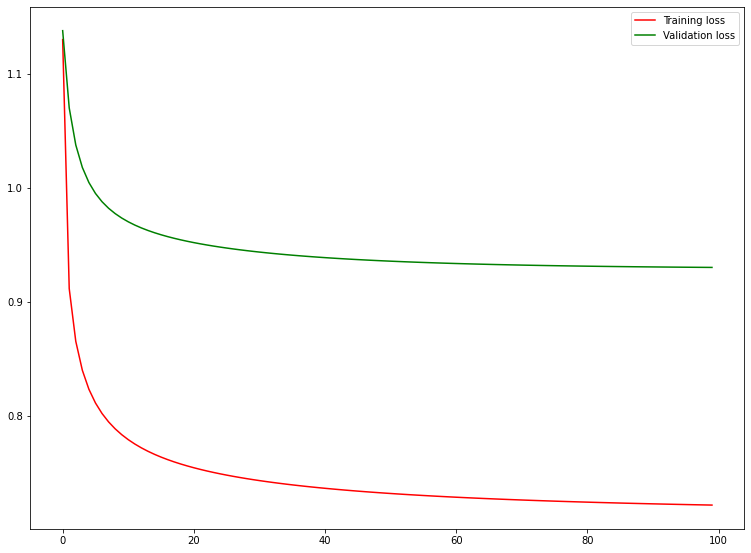

In [ ]:
train_loss, validation_loss = trainer_sentences.train(dataloader_sentences_train, 
                                                      dataloader_sentences_dev, 
                                                      PATH_MYMODEL_OUTPUT_FOLDER, 
                                                      epoch_start = 0, 
                                                      epochs = 100)

x_epoch = np.arange(0,100,1)
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
plt.plot(x_epoch, train_loss, c = "red", label = "Training loss")
plt.plot(x_epoch, validation_loss, c = "green", label = "Validation loss")
plt.legend()

###Evaluation
Evaluate, with the best model, the error rate of the development set and save the predictions of the test set

####Load the best model

In [60]:
# Save and test the error rate of the dev_set
best_model = MyModel(len(classes), model_word_embedding.embeddings, 300, 100)
best_model.load_state_dict(torch.load(os.path.join(PATH_MYMODEL_OUTPUT_FOLDER, 'state_{}.pt'.format(99))))
setup_train(best_model)

####On Development Set


*   Save predictions;
*   Compute the error rate.



In [69]:
save_predictions(PREDICTIONS, 
                 "predictions_test_dev.tsv", 
                 dataloader_sentences_dev,
                 best_model, 
                 classes)
!python "/content/drive/My Drive/NLP/nlp_2022-bonus_exercise_1/code/scorer.py" \
        --prediction_file "/content/drive/My Drive/NLP/nlp_2022-bonus_exercise_1/code/predictions/predictions_test_dev.tsv" \
        --gold_file "/content/drive/My Drive/NLP/nlp_2022-bonus_exercise_1/code/gold/gold_dev.tsv"

Batch: 0it [00:00, ?it/s]

{'err_rate': '27.63'}


####On Test Set


*   Save predictions;

In [70]:
save_predictions(TEST_PREDICTION, 
                 "predictions_test.tsv", 
                 dataloader_sentences_test,
                 best_model, 
                 classes)

Batch: 0it [00:00, ?it/s]